<a href="https://colab.research.google.com/github/yuleidner/DAV-6150/blob/main/M5_assn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Science: Module 5
## Practical Challenge: Classification Model Performance Metrics
### Jacob Goodman & Alan Leidner
#### Oct 17, 2021
Assignment: https://yu.instructure.com/courses/50398/assignments/191953

## Introduction

The data set we are using for this work is comprised of  181 labeled binary observations (i.e., the classification is binary in nature). A classification model has been used to “predict” the classifications for each observation, and its algorithm works by estimating the probability that the correct classification for each observation is a ‘1’. The data set includes three attributes that we will make use of in our analysis:

1. class: the actual classification for the observation

2. scored.class: the predicted classification for the observation (can only be ‘0’ or ‘1’; identified by comparing the classification model’s probability score (i.e., the likelihood that the correct classification for an observation is a ‘1’) for the observation against a 0.50 threshold))

3. scored.probability: the classification model’s probability score (i.e., the likelihood that the correct classification for an observation is a ‘1’) for the observation

We will then create a custom class to measure the model's predictions in a number of ways including;
* Accuracy: the proportion of the total number of predictions that were correct
* Precision: the proportion of true positive cases that were correctly predicted
* Recall (or Sensitivity): the proportion of positive cases which were supposed to be returned
* Specificity: the proportion of actual negative cases which are correctly identified      
* F1 Score: a single measure that combines precision and recall (higher is better)

We will compare our results with the functions provided by sklearn.

We will then create a custom funtion to create a custom ROC curve and AUC score, and then compare them to the built-in sklearn functions.



## Import Dependencies

In [1]:
#import packages for data frames 
import numpy as np
import pandas as pd

#import functions to assess confusion matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

#import for roc visualizations and auc calculations
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.metrics import roc_curve
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import auc

## Load Data

In [2]:
# read a set of sample data from github. It contains information related to cars and insurance
filename = "https://raw.githubusercontent.com/yuleidner/DAV-6150/main/M5/M5_Data.csv"
df = pd.read_csv(filename)
pd.set_option('display.max_columns', None) #expands df to display all columns
df.head()

,pregnant,glucose,diastolic,skinfold,insulin,bmi,pedigree,age,class,scored.class,scored.probability
0,7,124,70,33,215,25.5,0.161,37,0,0,0.328452
1,2,122,76,27,200,35.9,0.483,26,0,0,0.273190
2,3,107,62,13,48,22.9,0.678,23,1,0,0.109660
3,1,91,64,24,0,29.2,0.192,21,0,0,0.055998
4,4,83,86,19,0,29.3,0.317,34,0,0,0.100491


## Creating Cross Tab

1. We will now construct a coefficient matrix utilizing the crosstab() method for use as a input in our functions. For a prettier output we will convert our input data to Boolean format and name our column and index to help users understand what they represent.

2. We will also save our y_pred, y_true and scored.probability columns in its own variables for use later in the assignement.


In [3]:
#1.creating crosstab
df_crosstab = pd.crosstab(df['class'].astype('bool'), df['scored.class'].astype('bool'),
                          rownames=['predicted_diabetic'], 
                          colnames=['true_diabetic'])

#2. storing variables
scored_probablity = df['scored.probability']
y_pred = df['scored.class']
y_true = df['class']

# sainty check the crosstab
df_crosstab

true_diabetic,False,True
predicted_diabetic,,
False,119,5
True,30,27


Our custom coefficient matrix confused us initially: the True/False values in the columns and rows were in the reverse order of classic coefficient matrixes. Be aware the true positives in this matrix are in the bottom right quadrant, false negatives in the top left etc.

## Create Custom Coefficient Class

We will now construct a class that will do the following. 
1. Store the seperate parts of the confusion matrix
2. Provide methods to calculate model statistics

> **Input:**

* This class should take as input a confusion matrix
* Matrix column and row names are expected to be either True/False or 1/0 

> **0n Initialization:**

* Split confusion matrix into consituent peices
  * true positives
  * false positives
  * true negatives
  * false nagatives
  * total observations

> **Availble Methods:** 

* accuracy
* precision
* recall
* spcificity
* f1
* fpr (false positive rate)


In [4]:
class coefmatrix:
    """ this class takes a Dataframe containing a Coefectiant matrix with column names of either 0,1 or True,False 
    and provides model stastics for binary models"""
    
    def __init__(self,df):
        self.crosstab = df
        # extract values from table
        #true positives
        try:
          self.TruePositives = df.loc[1,1] # True Positives
        except KeyError:
          self.TruePositives = 0
        #true negatives
        try:  
          self.TrueNegatives = df.loc[0,0] # True Negatives 
        except KeyError:
          self.TrueNegatives = 0
        #False positives
        try:  
          self.FalsePositives = df.loc[0,1] # False Positives
        except KeyError:
          self.FalsePositives = 0
        #False Negatives
        try:
          self.FalseNegatives = df.loc[1,0] # False Negatives
        except KeyError:
          self.FalseNegatives = 0
        #total records
        self.TotalRecords = df.values.sum()        

          
    def accuracy(self)  -> int:
        return (self.TruePositives+self.TrueNegatives)/self.TotalRecords

    def precision(self)  -> int:
        return self.TruePositives/(self.TruePositives+self.FalsePositives)
    
    def recall(self)  -> int: #sometimes called 'sensitivity'
        return self.TruePositives/(self.TruePositives+self.FalseNegatives) 
    
    def specificity(self) -> int:
        return self.TrueNegatives/(self.TrueNegatives+self.FalsePositives)

    def f1(self) -> int:
        return 2*self.precision()*self.recall()/(self.precision()+self.recall())

    def fpr(self)  -> int: # false positive rate to be utilized in ROC curve function
        return self.FalsePositives/(self.TrueNegatives+self.FalsePositives)
      


## Comparing class metrics to prebuilt 
We will now compare our class metrics to prebuild metrics  
steps:

1. Initialize a member of our new class
2. Compare each class method to an sklearn.metrics function


In [5]:
#initializing class object
matrix = coefmatrix(df_crosstab)

### confusion_matrix()

In [6]:
display(confusion_matrix( df['class'], df['scored.class']))
print('\n')
matrix.crosstab

array([[119,   5],
       [ 30,  27]])

true_diabetic,False,True
predicted_diabetic,,
False,119,5
True,30,27


**conclusion:**  
Our values match and our dataframe provides the more 'sophisticated' output we are used to.

### accuracy_score()


In [7]:
print(f'sklearn.accuracy_score: {accuracy_score(y_true,y_pred)}')
print(f'matrix.accuracy:        {matrix.accuracy()}')

sklearn.accuracy_score: 0.8066298342541437
matrix.accuracy:        0.8066298342541437


**conclusion:** our function matches sklearns
### precision_score()

In [8]:
print(f'sklearn.precision_score: {precision_score(y_true,y_pred)}')
print(f'matrix.precision:        {matrix.precision()}')

sklearn.precision_score: 0.84375
matrix.precision:        0.84375


**conclusion:** our function matches sklearns

### recall() or "sensitivity"

In [9]:
print(f'sklearn.recall_score: {recall_score(y_true,y_pred)}')
print(f'matrix.recall:        {matrix.recall()}')

sklearn.recall_score: 0.47368421052631576
matrix.recall:        0.47368421052631576


**conclusion:** our function matches sklearns

### f1_score()

In [10]:
print(f'sklearn.f1_score: {f1_score(y_true,y_pred)}')
print(f'matrix.f1:        {matrix.f1()}')

sklearn.f1_score: 0.6067415730337079
matrix.f1:        0.6067415730337079


**conclusion:** our function matches sklearns

### classification_report()

In [11]:
print(classification_report(y_true,y_pred))

              precision    recall  f1-score   support

           0       0.80      0.96      0.87       124
           1       0.84      0.47      0.61        57

    accuracy                           0.81       181
   macro avg       0.82      0.72      0.74       181
weighted avg       0.81      0.81      0.79       181



**conclusions:**   
Using the Classification report we verify our specificity class function.
 
sklearns classification report has signifignalty less specificiy and a relativaly confusioning output. It can be useful but a lot of care has to be taken to make sure output is being interpreted correctly and an understanding of the limitations is known.



## ROC/AUC


**Understanding steps for ROC:**  

1. Set the number of thresholds or steps between 0,1 we want to calculate
2. For each of those steps calculate the rate at which records would be accurately or inaccurately classified if that step was threshold for a predication counting as true. (recall and false positive rate)
3. Store each recall and false positive rate to be plotted to create ROC graphic and to be utlized in AUC calcualtion


**Understanding steps for AUC:**

reference on the trapexoidal method:
https://onlinelibrary.wiley.com/doi/pdf/10.1002/9781119261087.app1


Steps it takes:
1. Break our threashold encoded data into a series of 2x2 matrixs encoding the 2 points between spots on the ROC graphic as a series of trapaezoids. 
2. Use numpys np.trapz function to integrate each *trapezoid*
3. Sum the totals together to get full area under the curve


### Custom Implementation

#### Function Creation

In [12]:
def ROC_curve_AUC(y_true,scored_probablity,number_of_points = 105 ):
  """
  caculates the ROC by caculating recall and false positive rate at all thresholds between .0 -1.04 and returns the results
  as a numpy array.

  Then calcualtes AUC by utlizing trapizodal method to integrate array.

  Return ROC array and AUC
  
    references ROC:
    * https://www.youtube.com/watch?v=afQ_DyKMxUo 
    * https://towardsdatascience.com/roc-curve-and-auc-from-scratch-in-numpy-visualized-2612bb9459ab
  
    references AUC:
    * https://github.com/akshaykapoor347/Compute-AUC-ROC-from-scratch-python/blob/master/AUCROCPython.ipynb
    * https://numpy.org/doc/stable/reference/generated/numpy.trapz.html
  """

  import numpy as np #best practice import deps in functions
  roc_point = np.array([]) #initialize ROC array 
  
  #iterate for number of points set as input calculating Recall and FPR for each 
  for i  in range(0,number_of_points,1):

    #create a new predicted array at current threashold
     threshold_vector = np.greater_equal(scored_probablity, i / number_of_points).astype(int)
     
     # initializ a coefficient object ie caculate model stastics
     coef = coefmatrix(pd.crosstab(y_true,threshold_vector))

      #store recall and false positive rate for threashold 
     roc_point = np.append(roc_point,[coef.fpr(),coef.recall()])
  
  #reshape array 2 columns wide -1 here means the # of rows is dynamic/unknown 
  ROC = roc_point.reshape(-1,2)

  # we will now utlize the ROC array to caculate AUC 
  #initalize calculation arrays
  fpr_array = [] 
  tpr_array = []

  #iterate over ROC array to create 2x2 trapezoid matrix's 
  for i in range(len(ROC)-1):
    point1 = ROC[i];
    point2 = ROC[i+1]
    tpr_array.append([point1[0], point2[0]])
    fpr_array.append([point1[1], point2[1]])

  #We use Trapezoidal rule to calculate the area under the curve by approximating the intergral 
  auc = sum(np.trapz(tpr_array,fpr_array))+1  # Don't 100% understand +1 here I get that return is actually area not under cruve +1 to invert but don't grok 

  return ROC, auc

#### Visualization

Text(0, 0.5, 'True Positive Rate')

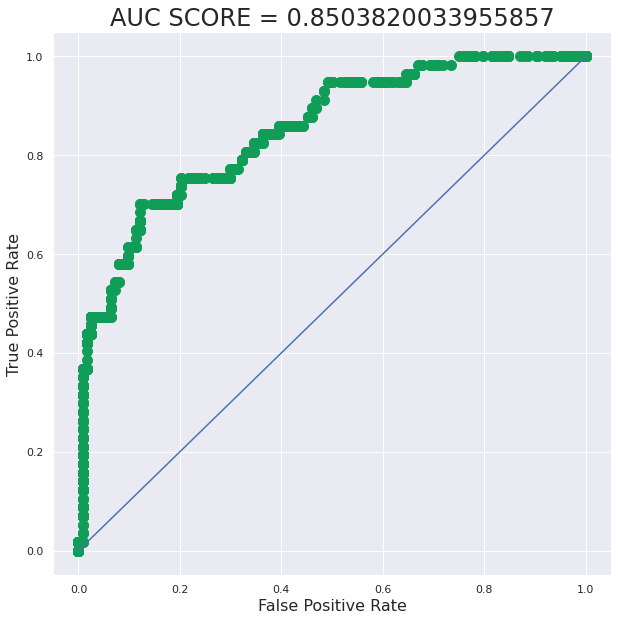

In [13]:
#ploting utlizing our from scratch function
sns.set()
plt.figure(figsize=(10,10))

ROC, AUC = ROC_curve_AUC(y_true,scored_probablity,number_of_points = 1005)
plt.title(f'AUC SCORE = {AUC}', fontsize=24)
plt.plot([0,1]);
plt.scatter(ROC[:,0],ROC[:,1],color='#0F9D58',s=100);
plt.xlabel('False Positive Rate',fontsize=16);
plt.ylabel('True Positive Rate',fontsize=16)

### Scikit-learn Implementation

We will now compare our custom roc/auc implementation to sklearn's built in functions.


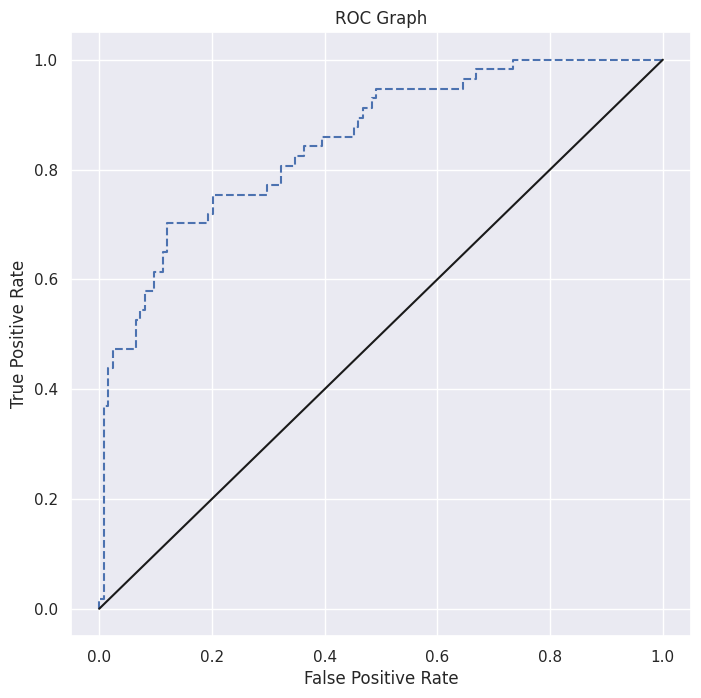

AUC = 0.8503112620260327


In [14]:
fpr, tpr, _ = roc_curve(y_true, scored_probablity)#defines true positive rate and false positive rates from initial dataset. The - stands in for threshholds, needed for the function, but not needed for our use
plt.figure(figsize =(8,8), dpi=100)
auc = auc(fpr, tpr)
plt.plot(fpr, tpr, linestyle = '--', label='auc (auc = %0.3f)' % auc)
plt.plot([0, 1], [0, 1],'k-')
plt.title('ROC Graph')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()
print(f'AUC = {auc}')

## Conclusion
Our AUC socre differs from the sklearn function at the 5th significant digit. We are not sure exactly what caused this difference, but assume it is due to insignificant differences in the cunstruction of our functions or threshhold groupings. Otherwise our roc curve matches the sklearn built in function very well.

We can see the advantages in building our own custom functions (extra nuanced control, and the ability to add functionality) but would likely use sklearn's built in libraries in future work.